# A few geostatistical concepts

To attempt to cover geostatistics in any depth in roughly one hour would be impossible. Thus, I plan to introduce a few concepts you may find useful below and we'll see how much we can cover. These may be fairly basic geostatistical examples, but hopefully the provide some general sense of how Python can be used for statistical analyses. The concepts we will cover (briefly) are:

- Least squares regressions (with and without weighting)
- Linear correlation
- Goodness-of-fit tests
- Monte Carlo inversion

## Least squares regressions

Least squares regressions can be used to fit a function to a scattered set of data points on an x-y plot. Typically we are fitting a line to the data, so we will use that example here as well.

### Unweighted least squares regressions

We can start with the idea that we want a line that fits a scattered set of x and y points. As you may recall, the equation for a line is

$$
\large
y = A + B x.
$$

Thus, to plot the line we would need to be able to find a slope $B$ and y-intercept $A$. We can find those values from our scatted x and y points using the following:

$$
\large
A = \frac{\sum{x^{2}} \sum{y} - \sum{x} \sum{xy}}{\Delta}
$$

where $x$ is the $i$th data point plotted on the $x$-axis, $y$ is the $i$th data point plotted on the $y$-axis, and $\Delta$ is defined below.

The line slope can be found using

$$
\large
B = \frac{N \sum{xy} - \sum{x} \sum {y}}{\Delta}
$$

where $N$ is the number of values in the regression.

And the value of $\Delta$ is

$$
\large
\Delta = N \sum{x^{2}} - \left( \sum{x} \right)^{2}
$$

Let's test this out for a set of x and y points below.

### Weighted least squares regressions

Let's now imagine a case where the values on the y-axis have some nominal uncertainties $\sigma$. We can modify our regression to include the uncertainties as weights for the point that are inversely proportional to the uncertainty:

$$
\large
w_{i} = 1 / \sigma_{i}^{2}
$$

where $i$ is the ith weight for the ith uncertainty.

We can thus modify our slope and intercept calculations above as follows:

$$
\large
A_{\mathrm{w}} = \frac{\sum{wx^{2}} \sum{wy} - \sum{wx} \sum{wxy}}{\Delta_{\mathrm{w}}},
$$

$$
\large
B_{\mathrm{w}} = \frac{\sum{w} \sum{wxy} - \sum{wx} \sum {wy}}{\Delta_{\mathrm{w}}},
$$

and 

$$
\large
\Delta_{\mathrm{w}} = \sum{w} \sum{wx^{2}} - \left( \sum{wx} \right)^{2}.
$$

Let's consider another example below.

### More information

Additional introductory information about least-squares regressions can be found on the [Introduction to Quantitative Geology course page](https://introqg-site.readthedocs.io/en/latest/notebooks/L2/least-squares.html).

## Linear correlation

The linear correlation coefficient $r$ measures how well a given set of points fit to a line, with values ranging from 1 for a perfect positive correlation to -1 for a perfect negative correlation. For a given set of x and y points, $r$ can be calculated as follows:

$$
\large
r = \frac{\sum{\left(x_{i} - \bar{x} \right)\left(y_{i} - \bar{y} \right)}}{\sqrt{\sum{\left(x_{i} - \bar{x} \right)^2} \sum{\left(y_{i} - \bar{y} \right)^2}}},
$$

where $\bar{x}$ and $\bar{y}$ are the means of the values on the x and y axes, respectively.

## Goodness-of-fit tests

Goodness-of-fit tests provide a way to quantify how well predictions fit a given set of observations that have known uncertainties. One common measure is the *weighted sum of the squared errors*, also often refered to simply as chi squared:

$$
\large
\chi^{2} = \sum \frac{(O_{i} - E_{i})^{2}}{\sigma_{i}^{2}}
$$

where $O_{i}$ is the $i$th observed value, $E_{i}$ is the $i$th expected value, and $\sigma_{i}$ is the $i$th standard deviation. For a given observation $i$, this equation will be less than 1 if the prediction falls within the uncertainties of the measurement or greater than 1 otherwise. This is fine, but it can then be confusing when the values are summed. Another option involves dividing by the number of values used in the calculation, as shown below.

$$
\large
\chi^{2} = \frac{1}{N} \sum \frac{(O_{i} - E_{i})^{2}}{\sigma_{i}^{2}}
$$

where $N$ is the number of values in the summation. This results in a $\chi^{2}$ value that should be less than 1 if the predictions are within the uncertainties *on average*, and greater than 1 otherwise.

## Monte Carlo inversions

### An example from thermal modelling

Consider the 1D heat transfer equation for steady-state heat conduction with radiogenic heat production:

$$
\begin{equation}
  T(x) = \frac{x T_{L}}{L} + \frac{h_{\mathrm{r}}^{2} H}{k} \left( \left( 1 - \exp{(-x / h_{\mathrm{r}})}\right) - \left( 1 - \exp{(-L / h_{\mathrm{r}})}\right) \frac{x}{L} \right)
\end{equation}
$$

where $T$ is temperature (°C), $x$ is depth (m), $T_{L}$ is the temperature at the base of the model (°C), $L$ is the model thickness (m), $H$ is the radiogenic heat production at the surface in (W/m$^{3}$), $h_{\mathrm{r}}$ is the depth at which the concentration of heat producing elements decreases by $1/e$ (m), and $k$ is the thermal conductivity in (W/m K).

If we have a study region where we would like to apply this model and we know the surface heat flow is 60±5 mW/m$^{2}$ and the crustal thickness is 35 km, then we could utilize a Monte Carlo inversion approach to 

| Parameter            | Minimum | Maximum |
|:---------------------|:-------:|:-------:|
| Basal temperature    | 500     | 750     |
| Heat production      | 1.5     | 3.0     |
| Characteristic depth | 10.0    | 35.0    |
| Thermal conductivity | 2.0     | 3.0     |

In [1]:
# Import the libraries we need
import numpy as np
import matplotlib.pyplot as plt


def rand_value(min_val, max_val):
    """Returns a random floating-point number between min_val and max_val"""
    number = (max_val - min_val) * np.random.rand() + min_val
    return number

def calculate_temperature(x, TL, H, hr, k):
    """Calculates a steady-state geotherm with heat production"""
    temperature = (x * TL) / x.max() + (hr**2 * H) / k * ((1 - np.exp(-x / hr)) - (1 - np.exp(-x.max() / hr)) * x / x.max())
    return temperature

def calculate_heat_flow(T, x, k, mantle_heat_flux=20.0):
    """Calculates surface heat flow from a geotherm"""
    mantle_heat_flux = mantle_heat_flux / 1000.0
    heat_flow = (T[1] - T[0]) / (x[1] - x[0]) * k + mantle_heat_flux
    return heat_flow

def make_scatter_plot(parameter1, parameter2, p1_min, p1_max, p2_min, p2_max, colors, cmap="plasma"):
    """Creates a scatter plot of two Monte Carlo model parameters"""
    # Create figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Create scatter plot
    im = ax.scatter(x=parameter1, y=parameter2, c=colors, cmap=cmap)
    
    # Set axis limits
    ax.set_xlim(p1_min, p1_max)
    ax.set_ylim(p2_min, p2_max)

    # Enable colorbar
    # NOTE: You can use LaTeX math formatting by enclosing text in dollar signs
    # I used it for superscript text here
    fig.colorbar(im, ax=ax, label="Heat flux (mW m$^{-2}$)")
    
    return fig, ax

In [2]:
# Define model geometry
L = 35000.0
x = np.linspace(0.0, L, 101)

# Configure Monte Carlo model below
# 10000 iterations is plenty for this kind of problem, but because a small percentage of the
# models fit the heat flow range, I opted for a larger number of iterations to fill in the
# plot a bit more
mc_iters = 100000

# Define measured heat flow
known_heat_flow = 70.0
heat_flow_uncertainty = 5.0

# Define parameter ranges
TL_min = 500.0
TL_max = 750.0
H_min = 1.5
H_max = 3.0
hr_min = 10000.0
hr_max = 35000.0
k_min = 2.0
k_max = 3.0

# Create lists for "good" parameters
TL_good = []
H_good = []
hr_good = []
k_good = []
hf_good = []

# Create MC sampler and comparison code
for i in range(mc_iters):
    TL = rand_value(TL_min, TL_max)
    H = rand_value(H_min, H_max) * 1e-6
    hr = rand_value(hr_min, hr_max)
    k = rand_value(k_min, k_max)
    
    # Calculate tempertures in the crust
    T = calculate_temperature(x, TL, H, hr, k)
    
    # Calculate heat flow
    heat_flow = calculate_heat_flow(T, x, k)
    
    # Check if we're in the heat flow range!
    if known_heat_flow - heat_flow_uncertainty <= heat_flow * 1000.0 <= known_heat_flow + heat_flow_uncertainty:
        TL_good.append(TL)
        H_good.append(H * 1e6)
        hr_good.append(hr)
        k_good.append(k)
        hf_good.append(heat_flow * 1000.0)

print(f"Number of models fitting the data: {len(hf_good)} ({len(hf_good) / mc_iters * 100.0} %)")

Number of models fitting the data: 6952 (6.952 %)


Text(0, 0.5, 'Characteristic depth (m)')

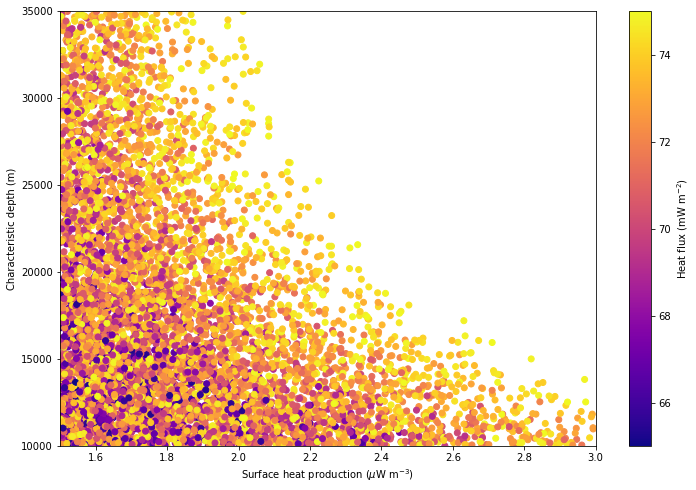

In [3]:
# Plot results here
# NOTE: The figure and axes are created in this function, but returned so we can still
# modify the plot after calling the function. This is handy because we might not know
# the axis labels when using the function.
fig, ax = make_scatter_plot(H_good, hr_good, H_min, H_max, hr_min, hr_max, hf_good)

# Add axis labels
# NOTE: Again, I used LaTeX math formatting by enclosing text in dollar signs
# I used it for the greek letter mu and superscript text here
ax.set_xlabel("Surface heat production ($\mu$W m$^{-3}$)")
ax.set_ylabel("Characteristic depth (m)")

## A concluding remark

There is more we could do at this point to further analyze the output to try to derive ranges of parameters that provide a suitable fit to the data, including calculating uncertainty bounds for the input parameters. The key point here is that with out model design, we can explore within a pre-defined range of parameters to be able to see which input values do or do not provide a heat flux that fits the data. Here, it is clear that if the heat production contributes too much (because of a high value or deep depth for the exponential decay), then the heat flow is too high and we cannot fit the heat flow bounds.